# Input Impedance Properties of the Model
    > Characterizing the parameter dependency of the input impedance spatial profile 


In [1]:
from single_cell_integration import initialize, load_params # code to run the model: (see content below)

import sys
sys.path.append('../../')
from neural_network_dynamics import nrn, utils
import plot_tools as pt
import matplotlib.pylab as plt
import numpy as np

### Locations where to simulate/record along the dendritic tree

Text(0.5, 1.0, 'n=4 points')

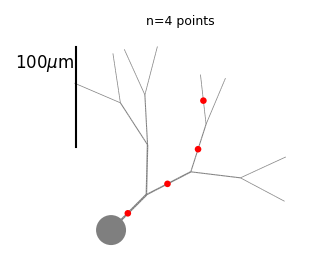

In [9]:
Model = load_params('BRT-parameters.json')
BRT, neuron = initialize(Model)
SEGMENTS = nrn.morpho_analysis.compute_segments(BRT)

vis = pt.nrnvyz(SEGMENTS)
n, N = Model['nseg_per_branch'], Model['branch-number']
BRANCH_LOCS = np.concatenate([np.arange(n+1),
                              1+40*N+np.arange(3*n)])
#BRANCH_LOCS = np.arange(n*N+1)
fig, ax = pt.plt.subplots(1, figsize=(2,2))
vis.plot_segments(ax=ax, color='tab:grey')
#vis.add_dots(ax, BRANCH_LOCS, 1)
BL = BRANCH_LOCS[10::20]
vis.add_dots(ax, BL, 10)
ax.set_title('n=%i points' % len(BL), fontsize=6)

In [10]:
BL

array([ 10, 170, 190, 210])

### Run Input Impedance Profile Characterization

In [26]:
from single_cell_integration import EXC_SYNAPSES_EQUATIONS, ON_EXC_EVENT

results = {'Nsyn':5, 'interstim':100}

taus = 5.*nrn.ms
w = 0.4*nrn.nS

for l, loc in enumerate(BL):
    
    case=str(loc)
    
    net, BRT, neuron = None, None, None
    stimulation, ES, M = None, None, None
    
    net, BRT, neuron = initialize(Model, with_network=True)


    spike_IDs, spike_times, synapses = np.empty(0, dtype=int), np.empty(0), np.empty(0, dtype=int)
    for e in range(results['Nsyn']):
        s = np.zeros(e+1)
        spike_times = np.concatenate([spike_times,
                                        (1+e)*results['interstim']+\
                                          np.arange(len(s))*nrn.defaultclock.dt/nrn.ms])
        spike_IDs = np.concatenate([spike_IDs, np.array(s, dtype=int)])

    results[case]['spike_times'] = spike_times
    results[case]['spike_IDs'] = spike_IDs

    stimulation = nrn.SpikeGeneratorGroup(1,
                                          np.array(spike_IDs, dtype=int),
                                          spike_times*nrn.ms)
    net.add(stimulation)
    ES = nrn.Synapses(stimulation, neuron,
                       model=EXC_SYNAPSES_EQUATIONS.format(**Model),
                       on_pre=ON_EXC_EVENT.format(**Model),
                       method='exponential_euler')

    ES.connect(i=0, j=loc)
    net.add(ES)
    # recording and running
    M = nrn.StateMonitor(neuron, ('v'), record=[0])
    net.add(M)
    nrn.run((200+np.max(spike_times))*nrn.ms)
    results[case]['Vm'] = np.array(M.v[0]/nrn.mV)
    
    results[case]['t'] = np.array(M.t/nrn.ms)

# np.save('results.npy', results)

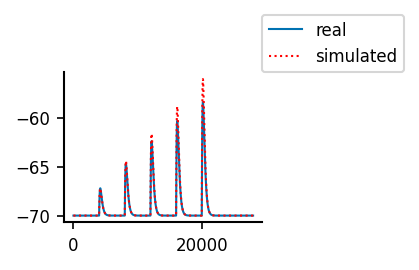

In [57]:
def build_linear_pred_trace(results):

    # build a dicionary with the individual responses
    
    for l, loc in enumerate(BL):
        
        case=str(loc)

        results[case]['depol-real'] = []
        results[case]['depol-linear'] = []
    
        results['%s-linear-pred' % case] = {'Vm':np.ones(len(results[case]['t']))*results[case]['Vm'][-1],
                                            't':results[case]['t']}

        # single syn kernel
        t_cond = (results[case]['t']>results['interstim']) &  (results[case]['t']<(1.9*results['interstim']))
        results['%s-single-syn-kernel' % case] = results[case]['Vm'][t_cond]-results[case]['Vm'][t_cond][0]

        for e in range(results['Nsyn']):
            start = ((1+e)*results['interstim'])
            i0 = np.flatnonzero(results[case]['t']>start)[0] 
            N=len(results['%s-single-syn-kernel' % case])
            results['%s-linear-pred' % case]['Vm'][i0:i0+N] += (1+e)*results['%s-single-syn-kernel' % case]
            # compute max depol
            results[case]['depol-real'].append(np.max(results[case]['Vm'][i0:i0+N])-\
                                                   results[case]['Vm'][i0])
            results[case]['depol-linear'].append(np.max(results['%s-linear-pred' % case]['Vm'][i0:i0+N])-\
                                                   results['%s-linear-pred' % case]['Vm'][i0])
            
    return results
results = build_linear_pred_trace(results)
pt.plt.plot(results['10']['Vm'], label='real')
pt.plt.plot(results['10-linear-pred']['Vm'], 'r:', label='simulated')
pt.plt.legend(loc=(1,1))

(1.0, 6.0)

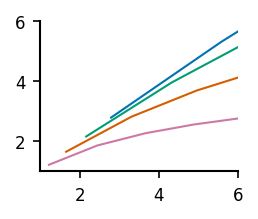

In [62]:
for l, loc in enumerate(BL):
    case=str(loc)
    pt.plt.plot(results[case]['depol-linear'], results[case]['depol-real'])

plt.xlim([1,6])
plt.ylim([1,6])
#results['10']['depol-linear'],